In [1]:
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

In [2]:
keywords = pd.read_csv('keywords_preprocessed.csv')
meta = pd.read_csv('movies_metadata_preprocessed.csv')
ratings = pd.read_csv('ratings_preprocessed.csv')

In [3]:
df_numeric = meta[['budget','popularity','revenue','runtime','vote_average','vote_count']]
df_numeric.dropna(inplace=True)
df_numeric['new'] = df_numeric['vote_average']*np.power(df_numeric['vote_count'],0.8)
train,test = train_test_split(df_numeric,test_size=0.25)



/Users/prajwalkirankumar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/prajwalkirankumar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
x = train.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.columns = df_numeric.columns

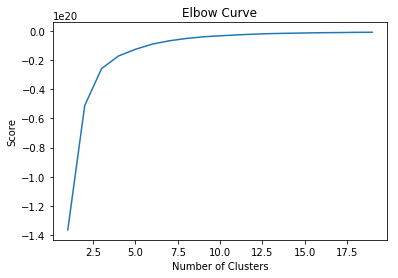

In [5]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
y = np.array(train.revenue).reshape(-1,1)
score = [kmeans[i].fit(y).score(y) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [6]:
kmeans = KMeans(n_clusters=4)
pred = kmeans.fit(y).predict(y)
train['cluster'] = kmeans.labels_


/Users/prajwalkirankumar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
[len(train[train.cluster==i]) for i in range(4)]

[31879, 310, 83, 1228]

In [16]:
# [train[train.cluster==i].revenue.mean() for i in range(4)]

In [17]:
train.groupby(['cluster']).mean()

,budget,popularity,revenue,runtime,vote_average,vote_count,new
cluster,,,,,,,
0,5.345002e+06,2.419895,8.626605e+06,92.877161,5.600910,45.779730,105.909107
1,8.814674e+07,16.132253,3.650732e+08,116.903226,6.561613,2429.674194,3343.460811
2,1.538494e+08,47.884365,9.146887e+08,130.481928,6.969880,5671.795181,7057.303734
3,4.140856e+07,10.843562,1.192532e+08,118.833876,6.341694,858.131922,1356.147294


budget


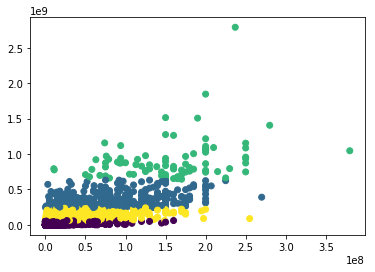

popularity


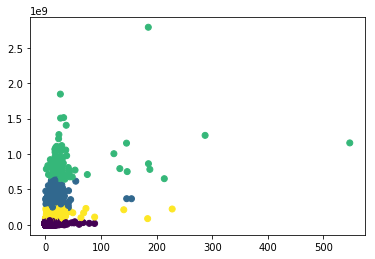

revenue


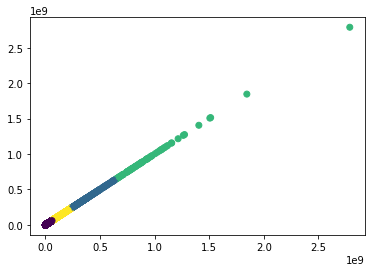

runtime


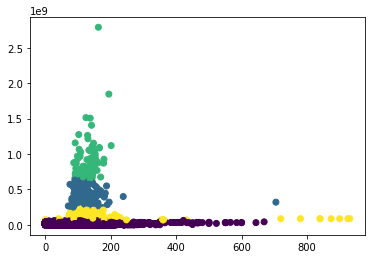

vote_average


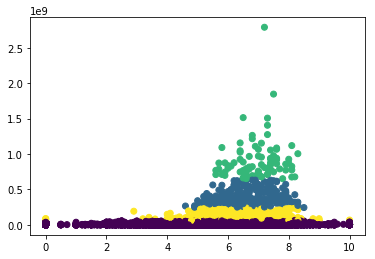

vote_count


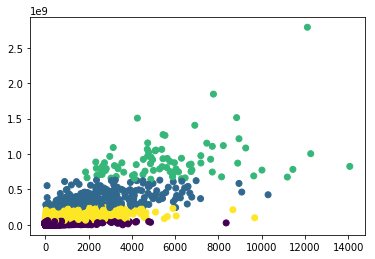

new


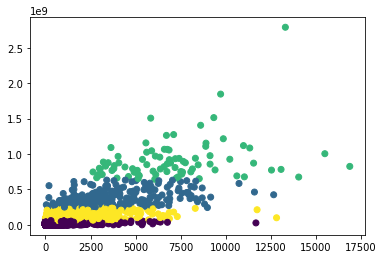

cluster


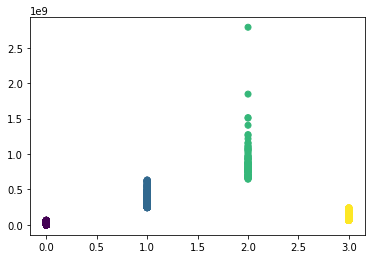

In [19]:
size_array = list(train.groupby(['cluster']).count()['revenue'].values)
train[train['cluster']==size_array.index(sorted(size_array)[0])].revenue.mean()
# plt.scatter(train.budget,train.revenue,c=kmeans.labels_)
# plt.show()
for i in train:
    plt.scatter(train[i],train['revenue'],c=kmeans.labels_)
    print(i)
    plt.show()

In [11]:
cluster1 = train[train.cluster==0]
cluster1 = cluster1[cluster1.revenue!=0]
len(cluster1)

31879

In [12]:
test_clusters = kmeans.predict(test.revenue.values.reshape(-1,1))
test['cluster'] = test_clusters
print(train.groupby(['cluster']).mean())
print(test.groupby(['cluster']).mean())

               budget  popularity       revenue     runtime  vote_average  \
cluster                                                                     
0        5.345002e+06    2.419895  8.626605e+06   92.877161      5.600910   
1        8.814674e+07   16.132253  3.650732e+08  116.903226      6.561613   
2        1.538494e+08   47.884365  9.146887e+08  130.481928      6.969880   
3        4.140856e+07   10.843562  1.192532e+08  118.833876      6.341694   

          vote_count          new  
cluster                            
0          45.779730   105.909107  
1        2429.674194  3343.460811  
2        5671.795181  7057.303734  
3         858.131922  1356.147294  
               budget  popularity       revenue     runtime  vote_average  \
cluster                                                                     
0        5.374555e+06    2.414952  8.674016e+06   93.297218      5.601980   
1        9.770609e+07   15.969069  3.808143e+08  116.495652      6.556522   
2        1.80

/Users/prajwalkirankumar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


/Users/prajwalkirankumar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


33986694.10661695


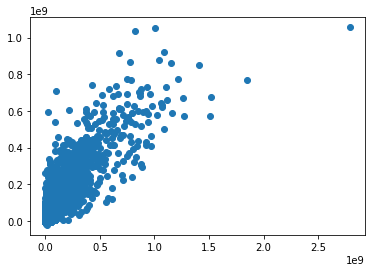

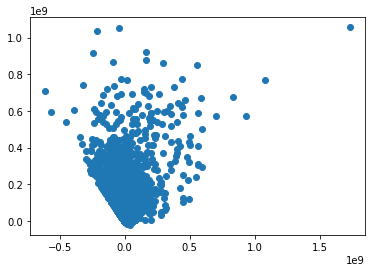

0.716615517039817


In [13]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error


X = train[['budget','popularity','runtime','new']]
y = train[['revenue']]

lm = linear_model.LinearRegression()
model = lm.fit(X,y)
predictions = lm.predict(X)
pred = pd.DataFrame(predictions,columns=["revenue"])
y['revenue_pred'] = predictions
# y = y[y.revenue_pred>0]

# log_y = np.log10(y.revenue)
# log_y_pred = np.log10(y.revenue_pred)
# print(mean_squared_error(log_y,log_y_pred))

print((mean_squared_error(y.revenue,y.revenue_pred))**0.5)


residuals = y.revenue - y.revenue_pred
plt.scatter(y.revenue,y.revenue_pred)
plt.show()
plt.scatter(residuals,y.revenue_pred)
plt.show()

print(model.score(X,y.revenue))

budget


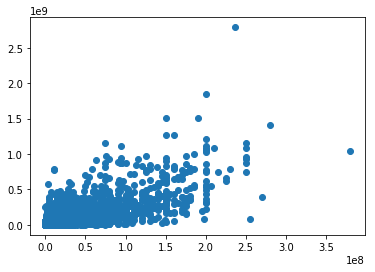

popularity


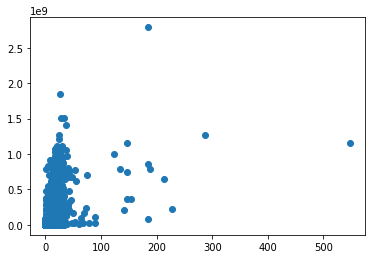

runtime


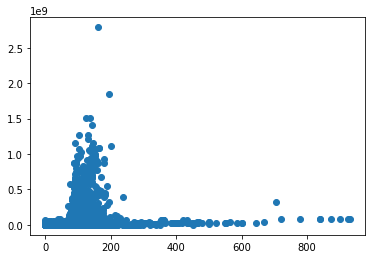

new


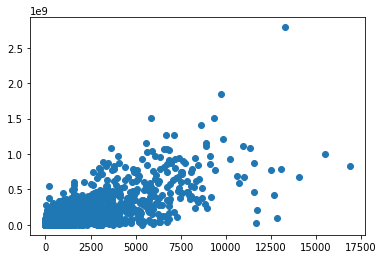

In [14]:
for i in X:
    plt.scatter(X[i],train['revenue'])
    print(i)
    plt.show()